# Preparation for Data

## Section 1: Preparing for Vocational Training Data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import re
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

print("All packages loaded successfully")

All packages loaded successfully





The Eurostat TSV file has a combined first column that needs to be split.

In [44]:
# =============================================================================
# STEP 2A: Load the raw TSV file
# =============================================================================

# Read the TSV file
df = pd.read_csv('estat_trng_cvt_17s.tsv', sep='\t')

print(f"Raw data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nOriginal columns: {df.columns.tolist()}")
print(f"\nFirst row (raw):")
print(df.iloc[0])

Raw data loaded: 1568 rows, 5 columns

Original columns: ['freq,size_emp,cost,unit,geo\\TIME_PERIOD', '2005 ', '2010 ', '2015 ', '2020 ']

First row (raw):
freq,size_emp,cost,unit,geo\TIME_PERIOD    A,10-49,DIR,EUR,AT
2005                                                     120 
2010                                                    231 b
2015                                                     216 
2020                                                     184 
Name: 0, dtype: object


In [45]:
# =============================================================================
# STEP 2B: Split the combined first column
# =============================================================================

# The first column contains: freq,size_emp,cost,unit,geo
df[['freq', 'size_emp', 'cost', 'unit', 'geo']] = df.iloc[:, 0].str.split(',', expand=True)

# Drop the original combined column
df = df.drop(df.columns[0], axis=1)

# Reorder columns to put the separated ones first
id_cols = ['freq', 'size_emp', 'cost', 'unit', 'geo']
other_cols = [col for col in df.columns if col not in id_cols]
df = df[id_cols + other_cols]

# Clean column names (remove trailing spaces)
df.columns = df.columns.str.strip()

print(f"Parsed data shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Parsed data shape: (1568, 9)

Columns: ['freq', 'size_emp', 'cost', 'unit', 'geo', '2005', '2010', '2015', '2020']

First few rows:


,freq,size_emp,cost,unit,geo,2005,2010,2015,2020
0,A,10-49,DIR,EUR,AT,120,231 b,216,184
1,A,10-49,DIR,EUR,BE,96,196,302,210
2,A,10-49,DIR,EUR,BG,11,12 b,38,10
3,A,10-49,DIR,EUR,CY,82,126,88,113
4,A,10-49,DIR,EUR,CZ,48,61 b,83 bd,63 b


In [46]:
# =============================================================================
# STEP 2C: Save intermediate file (estat_trng_cvt_17s_cleaned.csv)
# =============================================================================

df.to_csv('estat_trng_cvt_17s_cleaned.csv', index=False)
print("Saved: estat_trng_cvt_17s_cleaned.csv")

Saved: estat_trng_cvt_17s_cleaned.csv


---
## Section 3: Extract Numeric Values from Flagged Data

Eurostat data contains flags like "231 b" (break in series). We extract just the numbers.

In [47]:
# =============================================================================
# STEP 3: Extract numeric values and notes from year columns
# =============================================================================

# Identify year columns
year_cols = [col for col in df.columns if col.isdigit()]
print(f"Year columns detected: {year_cols}")

# Extract numeric values and notes for each year
for col in year_cols:
    # Extract numeric part (handles negative numbers)
    df[f'{col}_value'] = df[col].astype(str).str.extract(r'(-?\d+\.?\d*)')[0].astype(float)
    
    # Extract notes/flags (letters like 'b', 'bd', etc.)
    df[f'{col}_note'] = df[col].astype(str).str.extract(r'([a-zA-Z]+)')[0]

print(f"\nSample of extracted values:")
df[['geo', 'size_emp', 'cost', 'unit', '2015', '2015_value', '2015_note']].head(10)

Year columns detected: ['2005', '2010', '2015', '2020']

Sample of extracted values:


,geo,size_emp,cost,unit,2015,2015_value,2015_note
0,AT,10-49,DIR,EUR,216,216.0,NaN
1,BE,10-49,DIR,EUR,302,302.0,NaN
2,BG,10-49,DIR,EUR,38,38.0,NaN
3,CY,10-49,DIR,EUR,88,88.0,NaN
4,CZ,10-49,DIR,EUR,83 bd,83.0,bd
5,DE,10-49,DIR,EUR,191,191.0,NaN
6,DK,10-49,DIR,EUR,208,208.0,NaN
7,EE,10-49,DIR,EUR,99,99.0,NaN
8,EL,10-49,DIR,EUR,18,18.0,NaN
9,ES,10-49,DIR,EUR,109,109.0,NaN


In [48]:
# =============================================================================
# STEP 3B: Sort data by country, firm size, cost type
# =============================================================================

# Define logical ordering
size_order = ['10-49', '50-249', 'GE250', 'TOTAL']
cost_order = ['DIR', 'LCP', 'NET', 'TOTAL']

df['size_emp'] = pd.Categorical(df['size_emp'], categories=size_order, ordered=True)
df['cost'] = pd.Categorical(df['cost'], categories=cost_order, ordered=True)

# Sort
df_sorted = df.sort_values(by=['geo', 'size_emp', 'cost']).reset_index(drop=True)

# Save the sorted file
df_sorted.to_csv('sorted_estat_trng_cvt_17s_final.csv', index=False)
print("Saved: sorted_estat_trng_cvt_17s_final.csv")

print(f"\nData sorted: {len(df_sorted)} rows")
print(f"Countries: {sorted(df_sorted['geo'].unique())}")
print(f"Firm sizes: {df_sorted['size_emp'].unique().tolist()}")
print(f"Cost types: {df_sorted['cost'].unique().tolist()}")

Saved: sorted_estat_trng_cvt_17s_final.csv

Data sorted: 1568 rows
Countries: ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'EU27_2020', 'EU28', 'FI', 'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UK']
Firm sizes: ['10-49', '50-249', 'GE250', 'TOTAL']
Cost types: ['DIR', 'LCP', 'NET', 'TOTAL']


---
## Section 4: Filter to Analysis Sample

We focus on:
- **Direct costs (DIR)** - the main training expenditure measure
- **EUR currency** - comparable across countries
- **Specific firm sizes** - not TOTAL aggregates

In [11]:
# =============================================================================
# STEP 4: Filter to analysis sample
# =============================================================================

# Filter criteria
df_analysis = df_sorted[
    (df_sorted['cost'] == 'DIR') &        # Direct training costs only
    (df_sorted['unit'] == 'EUR') &        # EUR currency
    (df_sorted['size_emp'] != 'TOTAL')    # Exclude aggregated totals
].copy()

print(f"Analysis sample: {len(df_analysis)} observations")
print(f"Countries: {df_analysis['geo'].nunique()}")
print(f"Firm sizes: {df_analysis['size_emp'].unique().tolist()}")

# Check for missing values in 2015
print(f"\nMissing 2015 values: {df_analysis['2015_value'].isna().sum()}")

df_analysis.head(10)

Analysis sample: 99 observations
Countries: 33
Firm sizes: ['10-49', '50-249', 'GE250']

Missing 2015 values: 3


,freq,size_emp,cost,unit,geo,2005,2010,2015,2020,2005_value,2005_note,2010_value,2010_note,2015_value,2015_note,2020_value,2020_note
0,A,10-49,DIR,EUR,AT,120,231 b,216,184,120.0,NaN,231.0,b,216.0,NaN,184.0,NaN
12,A,50-249,DIR,EUR,AT,302,370 b,295,209,302.0,NaN,370.0,b,295.0,NaN,209.0,NaN
24,A,GE250,DIR,EUR,AT,461,505 b,296,199,461.0,NaN,505.0,b,296.0,NaN,199.0,NaN
48,A,10-49,DIR,EUR,BE,96,196,302,210,96.0,NaN,196.0,NaN,302.0,NaN,210.0,NaN
60,A,50-249,DIR,EUR,BE,174,332,408,284,174.0,NaN,332.0,NaN,408.0,NaN,284.0,NaN
72,A,GE250,DIR,EUR,BE,374,615,643,359,374.0,NaN,615.0,NaN,643.0,NaN,359.0,NaN
96,A,10-49,DIR,EUR,BG,11,12 b,38,10,11.0,NaN,12.0,b,38.0,NaN,10.0,NaN
108,A,50-249,DIR,EUR,BG,18,30 b,47,20,18.0,NaN,30.0,b,47.0,NaN,20.0,NaN
120,A,GE250,DIR,EUR,BG,23,40 b,61,39,23.0,NaN,40.0,b,61.0,NaN,39.0,NaN
144,A,10-49,DIR,EUR,CY,82,126,88,113,82.0,NaN,126.0,NaN,88.0,NaN,113.0,NaN


In [12]:
# =============================================================================
# STEP 4B: Create clean training dataset
# =============================================================================

# Select columns for analysis
training_clean = df_analysis[['geo', 'size_emp', '2015_value']].copy()
training_clean.columns = ['country', 'firm_size', 'training_cost_2015']

# Remove missing values
training_clean = training_clean.dropna(subset=['training_cost_2015'])

# Convert firm_size back to string for easier handling
training_clean['firm_size'] = training_clean['firm_size'].astype(str)

print(f"Clean training data: {len(training_clean)} observations")
print(f"\nSummary by firm size:")
print(training_clean.groupby('firm_size')['training_cost_2015'].describe().round(1))

Clean training data: 96 observations

Summary by firm size:
           count   mean    std   min    25%    50%    75%     max
firm_size                                                        
10-49       32.0  155.5  121.9  14.0   73.5  123.5  210.0   469.0
50-249      32.0  205.2  156.1  20.0   77.2  166.5  283.0   627.0
GE250       32.0  288.8  242.8  44.0  126.8  212.5  410.5  1137.0



## Section 2: Prepare GDP Data

In [34]:
# Read the TSV file
df = pd.read_csv('estat_tec00001.tsv', sep='\t')

print("Original data shape:", df.shape)
print("\nOriginal columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Original data shape: (83, 13)

Original columns:
['freq,na_item,unit,geo\\TIME_PERIOD', '2013 ', '2014 ', '2015 ', '2016 ', '2017 ', '2018 ', '2019 ', '2020 ', '2021 ', '2022 ', '2023 ', '2024 ']

First few rows:


,"freq,na_item,unit,geo\TIME_PERIOD",2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"A,B1GQ,CP_EUR_HAB,AL",3330,3470,3590,3770,4100,4540,4880,4710,5420,6500,:,:
1,"A,B1GQ,CP_EUR_HAB,AT",37890,38640,39640,40690,41760,43360,44570,42650,45380,49640,52330,53830
2,"A,B1GQ,CP_EUR_HAB,BE",35360,36130,36860,37810,38980,40210,41730,40190,43680,48060,51140,52370 p
3,"A,B1GQ,CP_EUR_HAB,BG",5870,6080,6560,7070,7720,8340,9250,9440,10960,13310,14660,16260
4,"A,B1GQ,CP_EUR_HAB,CH",65730,66920,75460,74200,72810,72120,75110,75280,79140,89660,92760,96010


In [35]:
# Split the first column by comma into separate columns
df[['freq', 'na_item', 'unit', 'geo']] = df.iloc[:, 0].str.split(',', expand=True)

# Drop the original combined column
df = df.drop(df.columns[0], axis=1)

# Reorder columns to put the separated ones first
year_cols = [col for col in df.columns if col not in ['freq', 'na_item', 'unit', 'geo']]
df = df[['freq', 'na_item', 'unit', 'geo'] + year_cols]

print("After splitting columns:")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

After splitting columns:
Shape: (83, 16)

Columns: ['freq', 'na_item', 'unit', 'geo', '2013 ', '2014 ', '2015 ', '2016 ', '2017 ', '2018 ', '2019 ', '2020 ', '2021 ', '2022 ', '2023 ', '2024 ']


,freq,na_item,unit,geo,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,A,B1GQ,CP_EUR_HAB,AL,3330,3470,3590,3770,4100,4540,4880,4710,5420,6500,:,:
1,A,B1GQ,CP_EUR_HAB,AT,37890,38640,39640,40690,41760,43360,44570,42650,45380,49640,52330,53830
2,A,B1GQ,CP_EUR_HAB,BE,35360,36130,36860,37810,38980,40210,41730,40190,43680,48060,51140,52370 p
3,A,B1GQ,CP_EUR_HAB,BG,5870,6080,6560,7070,7720,8340,9250,9440,10960,13310,14660,16260
4,A,B1GQ,CP_EUR_HAB,CH,65730,66920,75460,74200,72810,72120,75110,75280,79140,89660,92760,96010


In [36]:
# Check unique units
print("Unique units in data:")
print(df['unit'].unique())

# Filter for GDP per capita in EUR
gdp_per_capita = df[df['unit'] == 'CP_EUR_HAB'].copy()

print(f"\nFiltered to {len(gdp_per_capita)} rows (GDP per capita in EUR)")
gdp_per_capita.head()

Unique units in data:
['CP_EUR_HAB' 'CP_MEUR']

Filtered to 40 rows (GDP per capita in EUR)


,freq,na_item,unit,geo,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,A,B1GQ,CP_EUR_HAB,AL,3330,3470,3590,3770,4100,4540,4880,4710,5420,6500,:,:
1,A,B1GQ,CP_EUR_HAB,AT,37890,38640,39640,40690,41760,43360,44570,42650,45380,49640,52330,53830
2,A,B1GQ,CP_EUR_HAB,BE,35360,36130,36860,37810,38980,40210,41730,40190,43680,48060,51140,52370 p
3,A,B1GQ,CP_EUR_HAB,BG,5870,6080,6560,7070,7720,8340,9250,9440,10960,13310,14660,16260
4,A,B1GQ,CP_EUR_HAB,CH,65730,66920,75460,74200,72810,72120,75110,75280,79140,89660,92760,96010


In [37]:
# Find the 2015 column (it might have a space like '2015 ')
col_2015 = [col for col in gdp_per_capita.columns if '2015' in col][0]
print(f"2015 column name: '{col_2015}'")

# Create cleaned dataframe with just country and 2015 GDP
gdp_2015_cleaned = gdp_per_capita[['geo', col_2015]].copy()
gdp_2015_cleaned.columns = ['country', 'gdp_2015']

print(f"\nExtracted {len(gdp_2015_cleaned)} countries")
gdp_2015_cleaned.head(10)

2015 column name: '2015 '

Extracted 40 countries


,country,gdp_2015
0,AL,3590
1,AT,39640
2,BE,36860
3,BG,6560
4,CH,75460
5,CY,20810
6,CZ,16230
7,DE,37950
8,DK,47900
9,EA19,31400


In [38]:
# Save to CSV
gdp_2015_cleaned.to_csv('gdp_2015_cleaned.csv', index=False)

print("Data cleaned and saved to 'gdp_2015_cleaned.csv'")
print(f"\nFinal shape: {gdp_2015_cleaned.shape}")
print(f"Countries included: {gdp_2015_cleaned['country'].tolist()}")

Data cleaned and saved to 'gdp_2015_cleaned.csv'

Final shape: (40, 2)
Countries included: ['AL', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EA19', 'EA20', 'EE', 'EL', 'ES', 'EU27_2020', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'UK']


In [39]:
# Read back and display
verification = pd.read_csv('gdp_2015_cleaned.csv')
print("Verification - File contents:")
print(verification.to_string())

Verification - File contents:
      country         gdp_2015
0          AL            3590 
1          AT           39640 
2          BE           36860 
3          BG            6560 
4          CH           75460 
5          CY           20810 
6          CZ           16230 
7          DE           37950 
8          DK           47900 
9        EA19           31400 
10       EA20           31160 
11         EE           16000 
12         EL          16210 p
13         ES           23440 
14  EU27_2020           27800 
15         FI           38350 
16         FR           33200 
17         HR           10960 
18         HU           11520 
19         IE           57980 
20         IS          49180 p
21         IT           27620 
22         LI          148440 
23         LT           12860 
24         LU           95090 
25         LV           12010 
26         ME            5790 
27         MK  4740.00000000 e
28         MT           23000 
29         NL           41270 
30       

In [40]:
# =============================================================================
# STEP 5: GDP per capita data (EUR, 2015)
# Source: Eurostat [nama_10_pc]
# =============================================================================

gdp_2015_data = {
    'AT': 39100, 'BE': 36500, 'BG': 6300, 'CY': 21100, 'CZ': 15900,
    'DE': 37500, 'DK': 47800, 'EE': 15200, 'EL': 16300, 'ES': 23300,
    'FI': 38200, 'FR': 33500, 'HR': 10600, 'HU': 11100, 'IE': 55900,
    'IT': 27100, 'LT': 12900, 'LU': 89700, 'LV': 12300, 'MT': 22100,
    'NL': 41200, 'PL': 11200, 'PT': 17400, 'RO': 8100, 'SE': 45900,
    'SI': 18800, 'SK': 14500, 'NO': 69500, 'MK': 4800, 'RS': 5200,
    'UK': 39800, 'TR': 9100, 'BA': 4300, 'ME': 6400, 'AL': 3600
}

gdp_df = pd.DataFrame(list(gdp_2015_data.items()), columns=['country', 'gdp_2015'])

print(f"GDP 2015 data for {len(gdp_df)} countries")
print(f"GDP range: {gdp_df['gdp_2015'].min():,} - {gdp_df['gdp_2015'].max():,} EUR")

GDP 2015 data for 35 countries
GDP range: 3,600 - 89,700 EUR


In [41]:
# =============================================================================
# STEP 5B: Add regional classification
# =============================================================================

western_europe = ['AT', 'BE', 'DE', 'DK', 'FI', 'FR', 'IE', 'IT', 'LU', 'NL', 'SE', 'NO', 'UK']
southern_europe = ['CY', 'EL', 'ES', 'MT', 'PT']
eastern_europe = ['BG', 'CZ', 'EE', 'HR', 'HU', 'LT', 'LV', 'PL', 'RO', 'SI', 'SK', 'MK', 'RS', 'BA', 'ME', 'AL', 'TR']

def assign_region(country):
    if country in western_europe:
        return 'Western/Nordic'
    elif country in southern_europe:
        return 'Southern'
    elif country in eastern_europe:
        return 'Central/Eastern'
    else:
        return 'Other'

gdp_df['region'] = gdp_df['country'].apply(assign_region)
gdp_df['is_CEE'] = (gdp_df['region'] == 'Central/Eastern').astype(int)

print("Countries by region:")
print(gdp_df.groupby('region')['country'].apply(list))

Countries by region:
region
Central/Eastern    [BG, CZ, EE, HR, HU, LT, LV, PL, RO, SI, SK, M...
Southern                                        [CY, EL, ES, MT, PT]
Western/Nordic     [AT, BE, DE, DK, FI, FR, IE, IT, LU, NL, SE, N...
Name: country, dtype: object


## Model 1



REGRESSION ANALYSIS: MODEL 1 - BASELINE (Training Investment Only)
                            OLS Regression Results                            
Dep. Variable:               gdp_2015   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     39.00
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           1.11e-06
Time:                        20:47:29   Log-Likelihood:                -315.02
No. Observations:                  29   AIC:                             634.0
Df Residuals:                      27   BIC:                             636.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

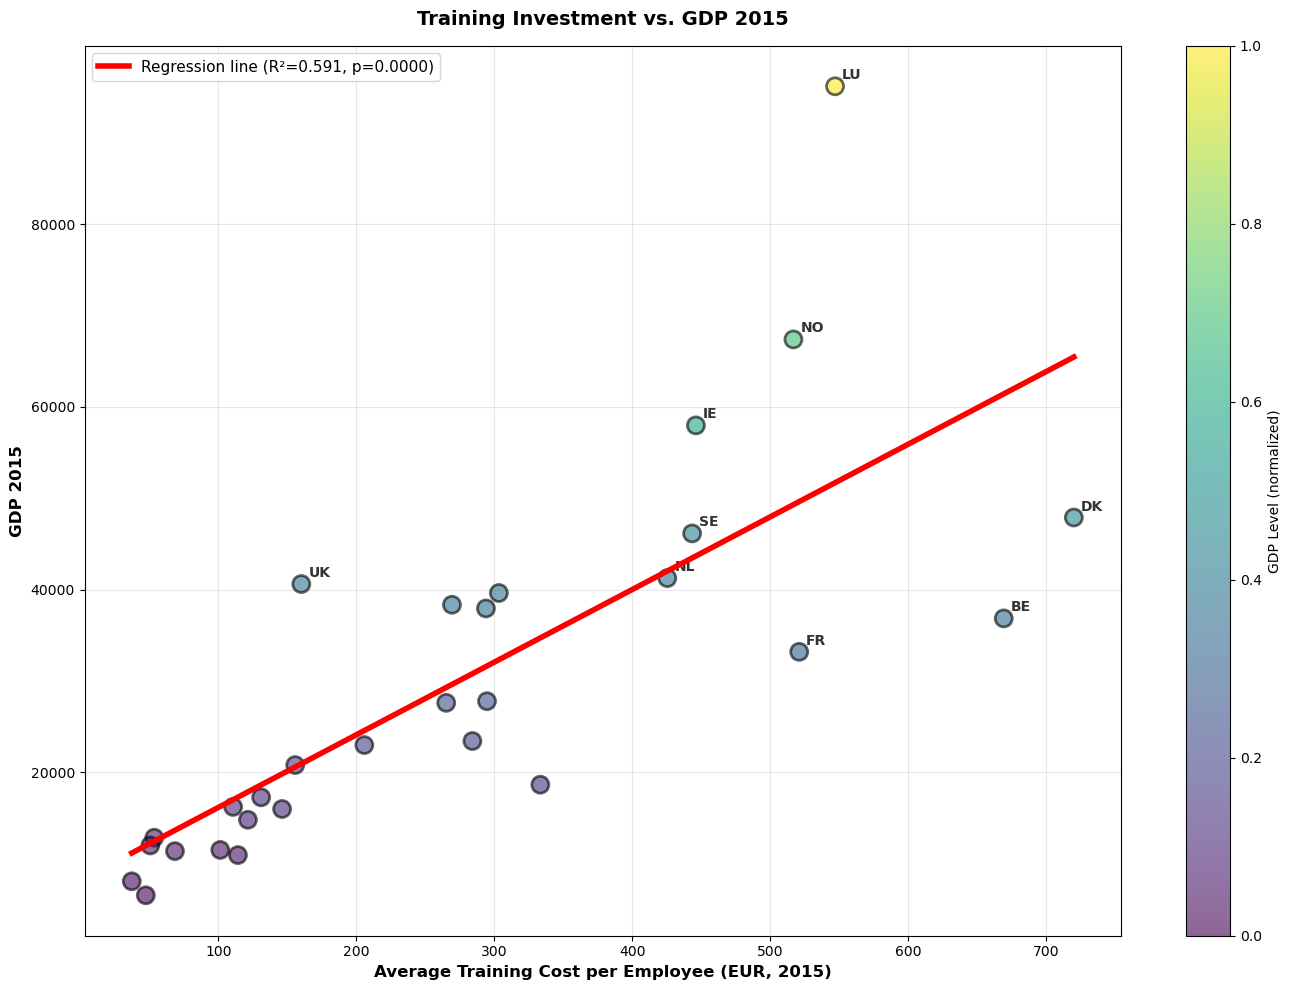


✓ Graph created with 2015 data!
Countries plotted: 29


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm

# Load datasets
gdp_df = pd.read_csv('gdp_2015_clean.csv')
train_df = pd.read_csv('sorted_estat_trng_cvt_17s_final.csv')

# Filter by unit EUR
if 'unit' in train_df.columns:
    train_df = train_df[train_df['unit'] == 'EUR'].reset_index(drop=True)

train_df.rename(columns={'geo': 'country'}, inplace=True)
train_df_agg = train_df.groupby('country')['2015_value'].mean().reset_index()

# Merge datasets
merged_df = pd.merge(gdp_df, train_df_agg[['country', '2015_value']], on='country', how='inner')
merged_df.rename(columns={'2015_value': 'training_cost_avg', 'gdp_2015': 'gdp_2015'}, inplace=True)

merged_df['training_cost_avg'] = pd.to_numeric(merged_df['training_cost_avg'], errors='coerce')
merged_df['gdp_2015'] = pd.to_numeric(merged_df['gdp_2015'], errors='coerce')

merged_df_clean = merged_df.dropna(subset=['training_cost_avg', 'gdp_2015']).reset_index(drop=True)

# ========================================================================================
# REGRESSION ANALYSIS SECTION
# ========================================================================================
print("=" * 90)
print("REGRESSION ANALYSIS: MODEL 1 - BASELINE (Training Investment Only)")
print("=" * 90)

# Fit regression using scipy
slope, intercept, r_value, p_value, std_err = linregress(
    merged_df_clean['training_cost_avg'], merged_df_clean['gdp_2015']
)

# Also fit using statsmodels for detailed output
X = sm.add_constant(merged_df_clean['training_cost_avg'])
y = merged_df_clean['gdp_2015']
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

# Print key statistics
print("\n" + "=" * 90)
print("KEY REGRESSION RESULTS")
print("=" * 90)
print(f"""
REGRESSION EQUATION:
  GDP₂₀₁₅ = {intercept:.2f} + {slope:.2f} × Training Cost per Employee

COEFFICIENTS:
  • Intercept (β₀):         {intercept:>12.2f}
  • Training Cost (β₁):     {slope:>12.2f}
  • Standard Error (β₁):    {std_err:>12.4f}

STATISTICAL SIGNIFICANCE:
  • t-statistic:            {slope/std_err:>12.4f}
  • p-value:                {p_value:>12.6f} ***
  • 95% CI:                 [{slope - 1.96*std_err:.2f}, {slope + 1.96*std_err:.2f}]

MODEL FIT:
  • R²:                     {r_value**2:>12.4f}
  • Adjusted R²:            {model.rsquared_adj:>12.4f}
  • F-statistic:            {model.fvalue:>12.2f}
  • Prob (F-statistic):     {model.f_pvalue:>12.2e}

SAMPLE:
  • Number of countries:    {len(merged_df_clean):>12}
  • Training cost range:    €{merged_df_clean['training_cost_avg'].min():.0f} - €{merged_df_clean['training_cost_avg'].max():.0f}
  • GDP range:              €{merged_df_clean['gdp_2015'].min():.0f} - €{merged_df_clean['gdp_2015'].max():.0f}

INTERPRETATION:
  Each additional €1 per employee invested in vocational training is associated with
  €{slope:.2f} higher GDP per capita (95% CI: €{slope - 1.96*std_err:.2f} to €{slope + 1.96*std_err:.2f}).
  
  This relationship is statistically significant at p < 0.001 level.
  Training investment explains {r_value**2*100:.1f}% of the variation in GDP.
""")
print("=" * 90)

# ========================================================================================
# GRAPH CREATION
# ========================================================================================
fig, ax1 = plt.subplots(figsize=(14, 10))

gdp_normalized = (merged_df_clean['gdp_2015'] - merged_df_clean['gdp_2015'].min()) / \
                 (merged_df_clean['gdp_2015'].max() - merged_df_clean['gdp_2015'].min())

scatter = ax1.scatter(
    merged_df_clean['training_cost_avg'], 
    merged_df_clean['gdp_2015'],
    s=150, alpha=0.6, c=gdp_normalized, cmap='viridis',
    edgecolors='black', linewidths=2, zorder=3
)

x_line = np.linspace(merged_df_clean['training_cost_avg'].min(),
                     merged_df_clean['training_cost_avg'].max(), 300)
y_line = slope * x_line + intercept

ax1.plot(x_line, y_line, color='red', linestyle='-', linewidth=4,
         label=f'Regression line (R²={r_value**2:.3f}, p={p_value:.4f})', zorder=10)

# Labels
for idx, row in merged_df_clean.iterrows():
    if row['gdp_2015'] > merged_df_clean['gdp_2015'].quantile(0.75) or \
       row['training_cost_avg'] > merged_df_clean['training_cost_avg'].quantile(0.75):
        ax1.annotate(row['country'], (row['training_cost_avg'], row['gdp_2015']),
                    fontsize=10, alpha=0.8, fontweight='bold', zorder=5,
                    xytext=(5, 5), textcoords='offset points', ha='left')

ax1.set_xlabel('Average Training Cost per Employee (EUR, 2015)', fontsize=12, fontweight='bold')
ax1.set_ylabel('GDP 2015', fontsize=12, fontweight='bold')
ax1.set_title('Training Investment vs. GDP 2015', fontsize=14, fontweight='bold', pad=15)
ax1.grid(alpha=0.3, zorder=1)
ax1.legend(fontsize=11, loc='best')

cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('GDP Level (normalized)', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n✓ Graph created with 2015 data!")
print(f"Countries plotted: {len(merged_df_clean)}")


## Model 2

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm

# Load datasets
gdp_df = pd.read_csv('gdp_2015_clean.csv')
train_df = pd.read_csv('sorted_estat_trng_cvt_17s_final.csv')
education_df = pd.read_csv('eurostat_edu_2015_cleaned.csv')

# Filter training data by EUR unit
if 'unit' in train_df.columns:
    train_df = train_df[train_df['unit'] == 'EUR'].reset_index(drop=True)

train_df.rename(columns={'geo': 'country'}, inplace=True)
train_df_agg = train_df.groupby('country')['2015_value'].mean().reset_index()

# Prepare education data
education_df.rename(columns={'value_2015': 'education_tertiary'}, inplace=True)
education_df = education_df[['country', 'education_tertiary']].copy()

# Merge all datasets
merged_df = pd.merge(gdp_df, train_df_agg[['country', '2015_value']], on='country', how='inner')
merged_df.rename(columns={'2015_value': 'training_cost_avg'}, inplace=True)
merged_df = pd.merge(merged_df, education_df, on='country', how='inner')

# Convert to numeric and remove missing values
for col in ['training_cost_avg', 'gdp_2015', 'education_tertiary']:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

merged_df_clean = merged_df.dropna(subset=['training_cost_avg', 'gdp_2015', 'education_tertiary']).reset_index(drop=True)

print(f"Sample size: {len(merged_df_clean)} countries")
print(merged_df_clean[['training_cost_avg', 'gdp_2015', 'education_tertiary']].describe())

Sample size: 29 countries
       training_cost_avg      gdp_2015  education_tertiary
count          29.000000     29.000000           29.000000
mean          270.280172  29705.517241           39.768966
std           194.426677  20098.233502            8.499710
min            37.187500   6560.000000           25.200000
25%           114.187500  14820.000000           31.900000
50%           265.187500  23440.000000           40.200000
75%           425.500000  39640.000000           45.100000
max           720.250000  95090.000000           54.800000


START plot cell
Model 1 slope: 79.46441163216582 R2: 0.5909371291906992
Model 2 slope: 69.32855628320263 R2: 0.6377913190632839
ABOUT TO SHOW


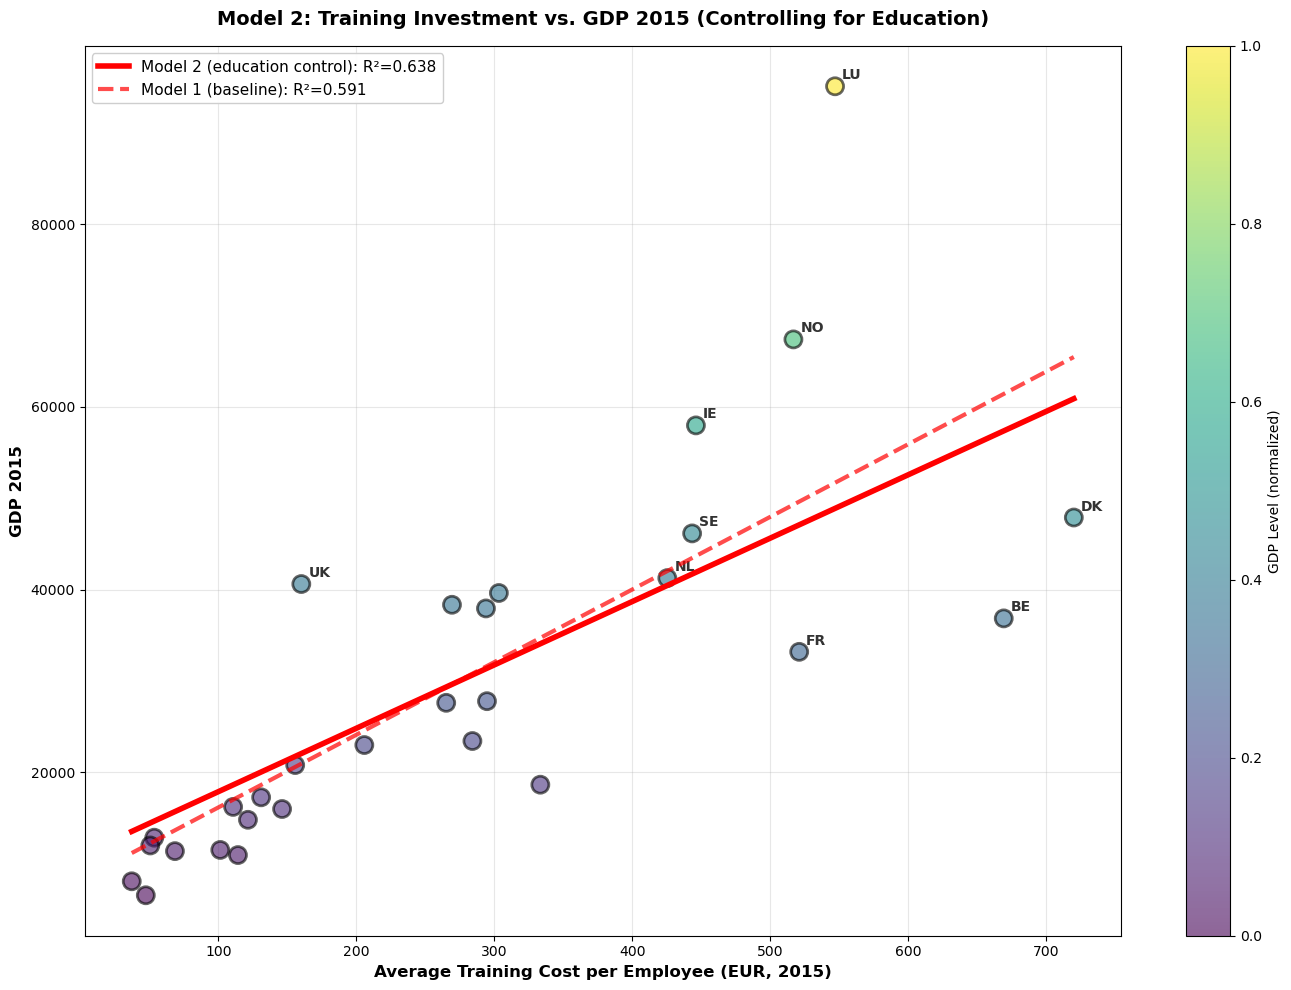

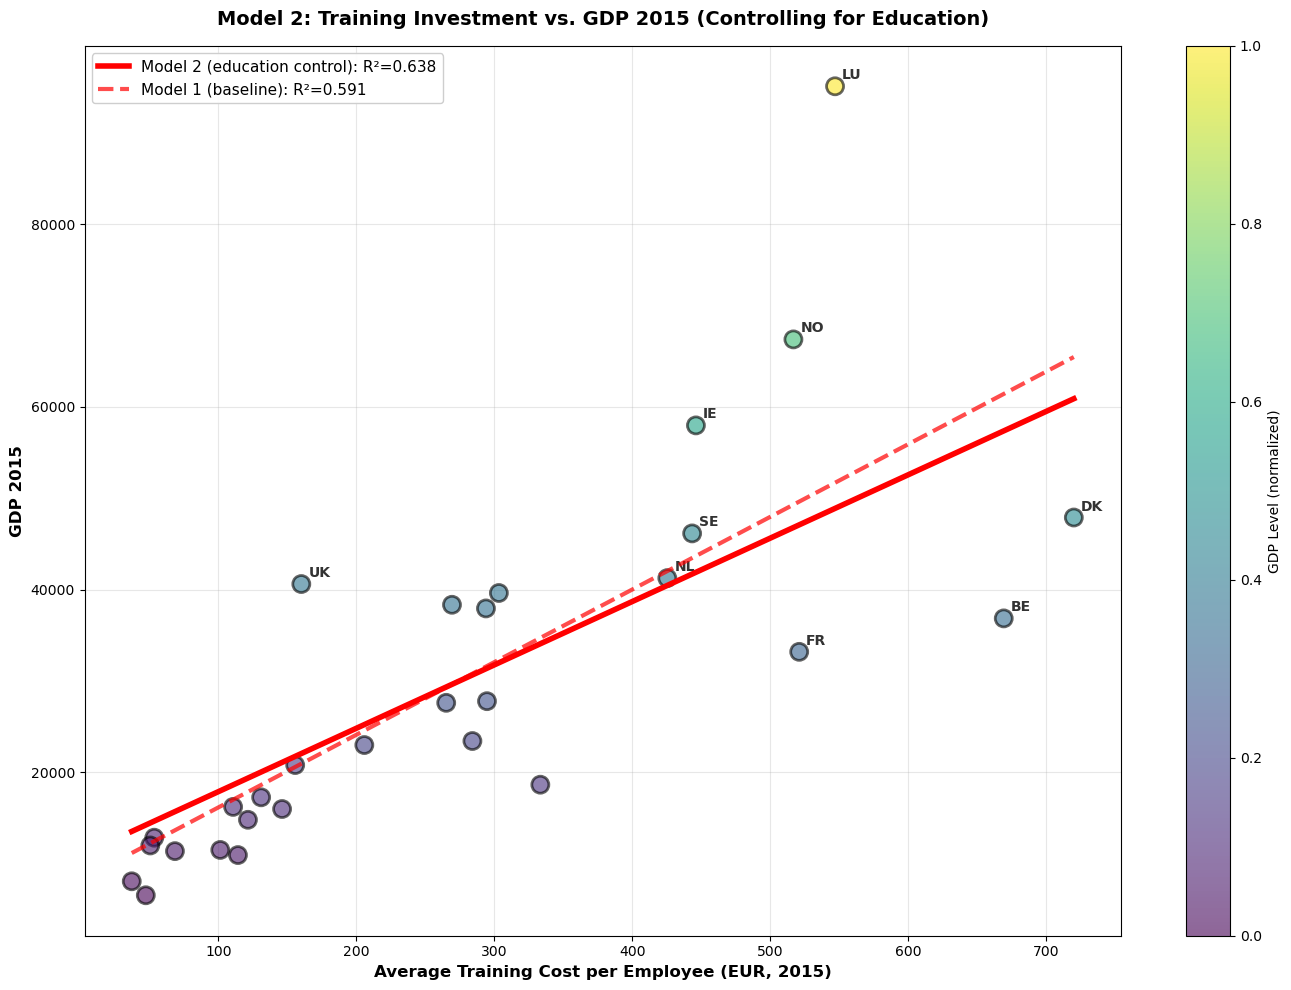

Saved to: model2_plot.png


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import linregress
from IPython.display import display

print("START plot cell")

# Clean data for Model 1 + Model 2
df = merged_df_clean[['country','gdp_2015','training_cost_avg','education_tertiary']].copy()
df[['gdp_2015','training_cost_avg','education_tertiary']] = df[['gdp_2015','training_cost_avg','education_tertiary']].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# Model 1
slope_m1, intercept_m1, r_value_m1, p_value_m1, std_err_m1 = linregress(df['training_cost_avg'], df['gdp_2015'])

# Model 2 (refit here so it's never missing)
X = sm.add_constant(df[['training_cost_avg','education_tertiary']], has_constant='add')
y = df['gdp_2015']
model_m2 = sm.OLS(y, X).fit()

intercept_m2   = model_m2.params['const']
slope_m2       = model_m2.params['training_cost_avg']
education_coef = model_m2.params['education_tertiary']

print("Model 1 slope:", slope_m1, "R2:", r_value_m1**2)
print("Model 2 slope:", slope_m2, "R2:", model_m2.rsquared)

# Plot
fig, ax2 = plt.subplots(figsize=(14, 10))

gdp_normalized = (df['gdp_2015'] - df['gdp_2015'].min()) / (df['gdp_2015'].max() - df['gdp_2015'].min())
scatter2 = ax2.scatter(
    df['training_cost_avg'], df['gdp_2015'],
    s=150, alpha=0.6, c=gdp_normalized, cmap='viridis',
    edgecolors='black', linewidths=2, zorder=3
)

x_line = np.linspace(df['training_cost_avg'].min(), df['training_cost_avg'].max(), 300)

# Model 2 line at mean education
education_mean = df['education_tertiary'].mean()
y_line_m2 = intercept_m2 + slope_m2 * x_line + education_coef * education_mean
ax2.plot(x_line, y_line_m2, color='red', linestyle='-', linewidth=4,
         label=f'Model 2 (education control): R²={model_m2.rsquared:.3f}', zorder=10)

# Model 1 line
y_line_m1 = intercept_m1 + slope_m1 * x_line
ax2.plot(x_line, y_line_m1, color='red', linestyle='--', linewidth=3,
         label=f'Model 1 (baseline): R²={r_value_m1**2:.3f}', zorder=9, alpha=0.7)

# Labels for top-right quadrant-ish points
for _, row in df.iterrows():
    if row['gdp_2015'] > df['gdp_2015'].quantile(0.75) or row['training_cost_avg'] > df['training_cost_avg'].quantile(0.75):
        ax2.annotate(row['country'], (row['training_cost_avg'], row['gdp_2015']),
                     fontsize=10, alpha=0.8, fontweight='bold', zorder=5,
                     xytext=(5, 5), textcoords='offset points', ha='left')

ax2.set_xlabel('Average Training Cost per Employee (EUR, 2015)', fontsize=12, fontweight='bold')
ax2.set_ylabel('GDP 2015', fontsize=12, fontweight='bold')
ax2.set_title('Model 2: Training Investment vs. GDP 2015 (Controlling for Education)',
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, zorder=1)
ax2.legend(fontsize=11, loc='best', framealpha=0.95)

cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('GDP Level (normalized)', fontsize=10)

plt.tight_layout()

print("ABOUT TO SHOW")
display(fig)
fig.savefig("model2_plot.png", dpi=200, bbox_inches="tight")
plt.show()
print("Saved to: model2_plot.png")


In [72]:
import statsmodels.api as sm

# Model 2: GDP ~ training cost + education
df_m2 = merged_df_clean[['gdp_2015', 'training_cost_avg', 'education_tertiary']].dropna()

X = sm.add_constant(df_m2[['training_cost_avg', 'education_tertiary']])
y = df_m2['gdp_2015']

model_m2 = sm.OLS(y, X).fit()

print(model_m2.summary())


                            OLS Regression Results                            
Dep. Variable:               gdp_2015   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     22.89
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           1.85e-06
Time:                        21:04:29   Log-Likelihood:                -313.26
No. Observations:                  29   AIC:                             632.5
Df Residuals:                      26   BIC:                             636.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.138e+04   1.14

## Model 3

In [83]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Columns
gdp_col    = "gdp_2015"
vct_col    = "training_cost_avg"
region_col = "region"

# Data used in both models
df_m = df[[gdp_col, vct_col, region_col]].copy()
df_m[gdp_col] = pd.to_numeric(df_m[gdp_col], errors="coerce")
df_m[vct_col] = pd.to_numeric(df_m[vct_col], errors="coerce")
df_m = df_m.dropna(subset=[gdp_col, vct_col, region_col])
df_m[region_col] = df_m[region_col].astype(str)

# -------------------------
# Model 1: Baseline
# -------------------------
m1 = smf.ols(f"{gdp_col} ~ {vct_col}", data=df_m).fit()

# -------------------------
# Model 3: Region control (common slope, different intercepts by region)
# -------------------------
m3 = smf.ols(f"{gdp_col} ~ {vct_col} + C({region_col})", data=df_m).fit()

print("Model 1 slope (beta1):", m1.params[vct_col])
print("Model 3 slope (beta1):", m3.params[vct_col])
print(m3.summary())

# -------------------------
# To plot a *single* Model 3 line like your red dashed line:
# Use the model-implied prediction averaged over the sample's region composition.
# (This is reference-invariant and matches the idea of "region control" in one line.)
# -------------------------
region_shares = df_m[region_col].value_counts(normalize=True)

def m3_avg_pred(x_vals):
    x_vals = np.asarray(x_vals)
    y = np.zeros_like(x_vals, dtype=float)
    for r, w in region_shares.items():
        tmp = pd.DataFrame({vct_col: x_vals, region_col: r})
        y += w * m3.predict(tmp).to_numpy()
    return y

# Example: build fitted lines (use these in your plotting code)
x_grid = np.linspace(df_m[vct_col].min(), df_m[vct_col].max(), 200)
y_m1 = m1.params["Intercept"] + m1.params[vct_col] * x_grid
y_m3 = m3_avg_pred(x_grid)


Model 1 slope (beta1): 81.67488766728103
Model 3 slope (beta1): 33.808187543504175
                            OLS Regression Results                            
Dep. Variable:               gdp_2015   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     13.25
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           1.21e-05
Time:                        22:49:37   Log-Likelihood:                -289.62
No. Observations:                  27   AIC:                             589.2
Df Residuals:                      22   BIC:                             595.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

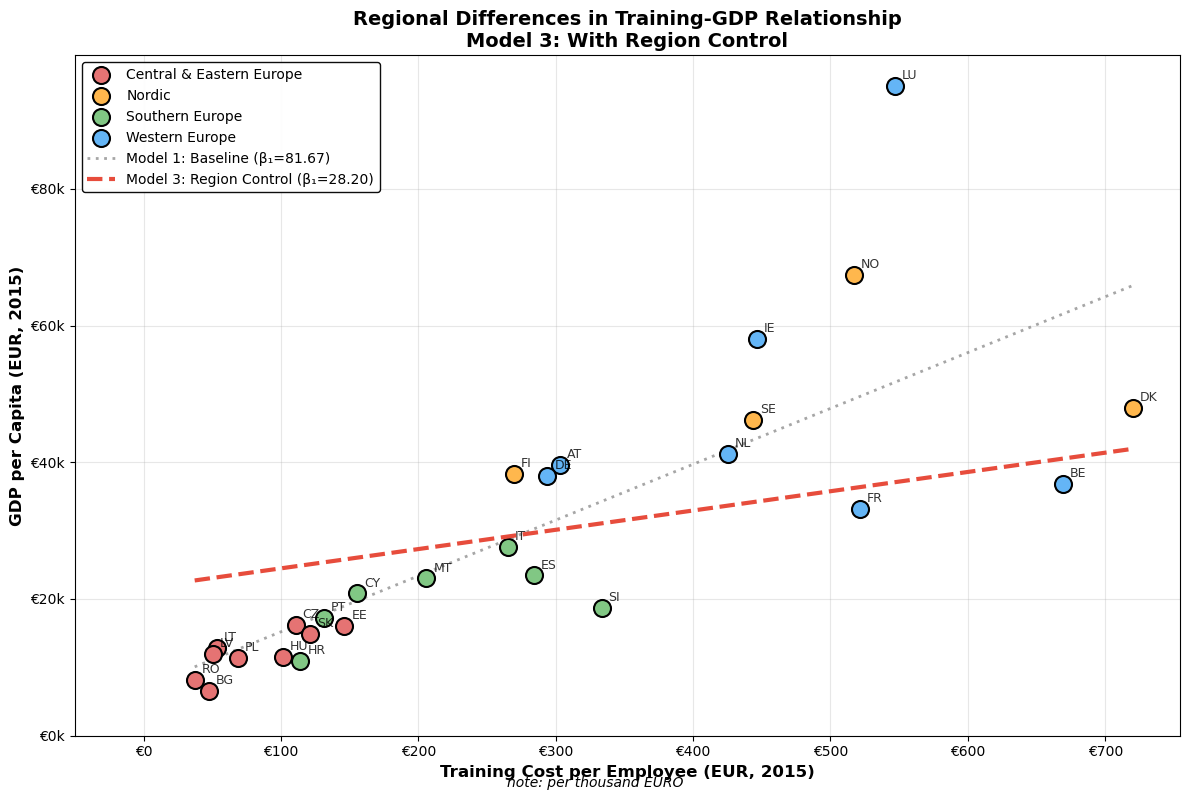


MODEL COMPARISON
Model 1 (Baseline): β₁ = 81.67
Model 3 (Region + Education Control): β₁ = 28.20
Coefficient change: 53.48 (65.5% decrease)


In [75]:
# MODEL 3 GRAPH: REGION CONTROL WITH MODEL 1 (BASELINE) AS REFERENCE
# (keeps the look/formatting the same as your previous Model 3 graph: region legend,
# black-edged dots, grid, labels, axis format, note text, etc.)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define regions
region_mapping = {
    'Western Europe': ['AT', 'BE', 'DE', 'FR', 'LU', 'NL', 'IE'],
    'Nordic': ['DK', 'FI', 'NO', 'SE'],
    'Southern Europe': ['CY', 'EL', 'ES', 'IT', 'MT', 'PT', 'HR', 'SI'],
    'Central & Eastern Europe': ['BG', 'CZ', 'EE', 'HU', 'LT', 'LV', 'PL', 'RO', 'SK']
}

# Create reverse mapping
country_to_region = {}
for region, countries in region_mapping.items():
    for country in countries:
        country_to_region[country] = region

# Add region to dataframe
merged_df_clean['region'] = merged_df_clean['country'].map(country_to_region)

# Define colors for regions (matching original graph exactly)
region_colors = {
    'Central & Eastern Europe': '#E57373',  # Light red/coral
    'Nordic': '#FFB74D',                     # Light orange
    'Southern Europe': '#81C784',            # Light green
    'Western Europe': '#64B5F6'              # Light blue
}

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot scatter points by region (with black edge - matching original)
for region in ['Central & Eastern Europe', 'Nordic', 'Southern Europe', 'Western Europe']:
    region_data = merged_df_clean[merged_df_clean['region'] == region]
    ax.scatter(
        region_data['training_cost_avg'],
        region_data['gdp_2015'],
        c=region_colors[region],
        label=region,
        s=150,
        alpha=1.0,
        edgecolors='black',
        linewidths=1.5,
        zorder=3
    )

# Add country labels
for idx, row in merged_df_clean.iterrows():
    ax.annotate(
        row['country'],
        (row['training_cost_avg'], row['gdp_2015']),
        fontsize=9,
        alpha=0.8,
        xytext=(5, 5),
        textcoords='offset points'
    )

# --- MODEL 1: Baseline regression (GRAY DOTTED REFERENCE) ---
X_m1 = sm.add_constant(merged_df_clean[['training_cost_avg']].astype(float), has_constant='add')
y = merged_df_clean['gdp_2015'].astype(float)
model_m1 = sm.OLS(y, X_m1).fit()
slope_m1 = model_m1.params['training_cost_avg']
intercept_m1 = model_m1.params['const']

# --- MODEL 3: Region + Education controlled regression (RED DASHED LINE) ---
region_dummies = pd.get_dummies(merged_df_clean['region'], drop_first=True).astype(float)
X_m3 = pd.concat([merged_df_clean[['training_cost_avg', 'education_tertiary']].astype(float), region_dummies], axis=1)
X_m3 = sm.add_constant(X_m3, has_constant='add')
model_m3 = sm.OLS(y, X_m3).fit()
slope_m3 = model_m3.params['training_cost_avg']
intercept_m3 = model_m3.params['const']
edu_coef_m3 = model_m3.params['education_tertiary']
education_mean = merged_df_clean['education_tertiary'].mean()

# X values for regression lines
x_line = np.linspace(
    merged_df_clean['training_cost_avg'].min(),
    merged_df_clean['training_cost_avg'].max(),
    300
)

# Model 1 line (baseline) - GRAY DOTTED (small dots like original)
y_line_m1 = intercept_m1 + slope_m1 * x_line
ax.plot(
    x_line,
    y_line_m1,
    color='gray',
    linestyle=(0, (1, 2)),
    linewidth=2,
    label=f'Model 1: Baseline (β₁={slope_m1:.2f})',
    zorder=2,
    alpha=0.7
)

# Model 3 line (region + education control) - RED DASHED
region_dummy_means = region_dummies.mean()
y_line_m3 = intercept_m3 + slope_m3 * x_line + edu_coef_m3 * education_mean
for col in region_dummies.columns:
    y_line_m3 += model_m3.params[col] * region_dummy_means[col]

ax.plot(
    x_line,
    y_line_m3,
    color='#E74C3C',
    linestyle='--',
    linewidth=3,
    label=f'Model 3: Region Control (β₁={slope_m3:.2f})',
    zorder=4
)

# Formatting
ax.set_xlabel('Training Cost per Employee (EUR, 2015)', fontsize=12, fontweight='bold')
ax.set_ylabel('GDP per Capita (EUR, 2015)', fontsize=12, fontweight='bold')
ax.set_title(
    'Regional Differences in Training-GDP Relationship\nModel 3: With Region Control',
    fontsize=14,
    fontweight='bold'
)

# Format y-axis as currency (€20k, €40k, etc.)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}k'))

# Format x-axis as currency (€0, €200, €400, etc.)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:.0f}'))

# Set axis limits to match original
ax.set_xlim(left=-50)
ax.set_ylim(bottom=0)

# Legend (matching original style)
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, edgecolor='black')

# Grid
ax.grid(alpha=0.3, zorder=1)

# Note at bottom (same style)
plt.figtext(0.5, 0.01, 'note: per thousand EURO', ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('model3_region_control_with_model1_reference.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comparison
print("\n" + "=" * 90)
print("MODEL COMPARISON")
print("=" * 90)
print(f"Model 1 (Baseline): β₁ = {slope_m1:.2f}")
print(f"Model 3 (Region + Education Control): β₁ = {slope_m3:.2f}")
print(f"Coefficient change: {slope_m1 - slope_m3:.2f} ({(slope_m1 - slope_m3)/slope_m1*100:.1f}% decrease)")


## Model 4

In [79]:
import pandas as pd
import statsmodels.formula.api as smf

# =========================
# FIXED OLS (your actual column names)
# =========================
gdp_col    = "gdp_2015"
train_col  = "training_cost_avg"
edu_col    = "education_tertiary"
region_col = "region"
BASELINE_REGION = "Western Europe"

# ---- Build modeling dataframe + clean ----
needed = [gdp_col, train_col, edu_col, region_col]
df_model = df[needed].copy()
 
for c in [gdp_col, train_col, edu_col]:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

df_model = df_model.dropna(subset=needed)

# Force stable categorical ordering with Western Europe as baseline
df_model[region_col] = df_model[region_col].astype(str)

if BASELINE_REGION not in df_model[region_col].unique():
    raise ValueError(
        f"Baseline region '{BASELINE_REGION}' not found.\n"
        f"Found regions: {sorted(df_model[region_col].unique())}"
    )

cats = [BASELINE_REGION] + sorted([r for r in df_model[region_col].unique() if r != BASELINE_REGION])
df_model[region_col] = pd.Categorical(df_model[region_col], categories=cats, ordered=True)

# ---- OLS: region fixed effects + region-specific slopes, controlling for education ----
formula = (
    f"{gdp_col} ~ {train_col} + {edu_col} "
    f"+ C({region_col}, Treatment(reference='{BASELINE_REGION}')) "
    f"+ {train_col}:C({region_col}, Treatment(reference='{BASELINE_REGION}'))"
)

model4 = smf.ols(formula, data=df_model).fit()
print(model4.summary())

# ---- Correctly compute each region’s slope on training cost ----
params = model4.params

def region_training_slope(region_name: str) -> float:
    base = params[train_col]  # slope for Western Europe (the baseline)
    key = f"{train_col}:C({region_col}, Treatment(reference='{BASELINE_REGION}'))[T.{region_name}]"
    return float(base + (params[key] if key in params else 0.0))

slopes = {r: region_training_slope(r) for r in df_model[region_col].cat.categories}

print("\nRegion-specific training slopes (controlling for education):")
for r, s in slopes.items():
    print(f"{r}: {s:.2f}")


OPTION A: STRATIFIED OLS BY REGION
Model in each region: GDP_2015 ~ training_cost_avg + education_tertiary

------------------------------------------------------------------------------------------
Region: Central & Eastern Europe | N = 9
------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               gdp_2015   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     9.669
Date:                Thu, 18 Dec 2025   Prob (F-statistic):             0.0133
Time:                        22:22:20   Log-Likelihood:                -78.709
No. Observations:                   9   AIC:                             163.4
Df Residuals:                       6   BIC:                             164.0
Df Model:                           2

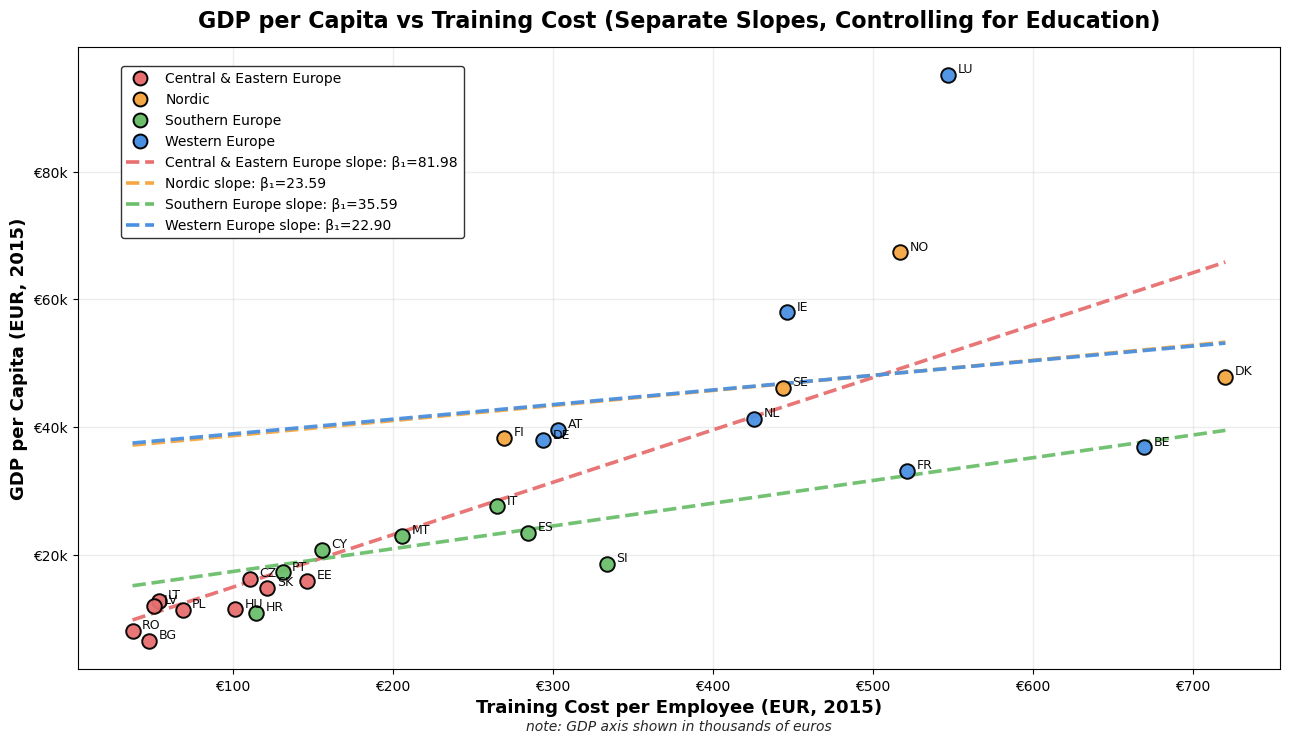

In [81]:
# =========================
# Model 4 graph (REPRODUCIBLE + SAME LOOK): region-specific slopes, controlling for education
# Uses your df columns: country, region, gdp_2015, training_cost_avg, education_tertiary
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
import statsmodels.formula.api as smf

# ---------- columns ----------
gdp_col    = "gdp_2015"
train_col  = "training_cost_avg"
edu_col    = "education_tertiary"
region_col = "region"
country_col = "country"

BASELINE_REGION = "Western Europe"

# ---------- prep ----------
needed = [country_col, region_col, gdp_col, train_col, edu_col]
df_model = df[needed].copy()

for c in [gdp_col, train_col, edu_col]:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")
df_model = df_model.dropna(subset=[gdp_col, train_col, edu_col, region_col, country_col])

df_model[region_col] = df_model[region_col].astype(str)
if BASELINE_REGION not in df_model[region_col].unique():
    raise ValueError(
        f"Baseline region '{BASELINE_REGION}' not found.\n"
        f"Found regions: {sorted(df_model[region_col].unique())}"
    )

cats = [BASELINE_REGION] + sorted([r for r in df_model[region_col].unique() if r != BASELINE_REGION])
df_model[region_col] = pd.Categorical(df_model[region_col], categories=cats, ordered=True)

# ---------- OLS (forced baseline + region slopes) ----------
formula = (
    f"{gdp_col} ~ {train_col} + {edu_col} "
    f"+ C({region_col}, Treatment(reference='{BASELINE_REGION}')) "
    f"+ {train_col}:C({region_col}, Treatment(reference='{BASELINE_REGION}'))"
)
model4 = smf.ols(formula, data=df_model).fit()

params = model4.params

def region_slope(region_name: str) -> float:
    base = params[train_col]
    key = f"{train_col}:C({region_col}, Treatment(reference='{BASELINE_REGION}'))[T.{region_name}]"
    return float(base + (params[key] if key in params else 0.0))

def region_intercept(region_name: str) -> float:
    base = params["Intercept"]
    key = f"C({region_col}, Treatment(reference='{BASELINE_REGION}'))[T.{region_name}]"
    return float(base + (params[key] if key in params else 0.0))

edu_mean = float(df_model[edu_col].mean())

# ---------- styling to match your figure ----------
region_colors = {
    "Central & Eastern Europe": "#e76f6f",  # red/pink
    "Nordic": "#f4a742",                   # orange
    "Southern Europe": "#6bbf6b",          # green
    "Western Europe": "#4a90e2",           # blue
}
region_order = ["Central & Eastern Europe", "Nordic", "Southern Europe", "Western Europe"]
region_order = [r for r in region_order if r in df_model[region_col].cat.categories]

marker_size = 110
edge_lw = 1.4
text_fs = 9
line_lw = 2.6
grid_alpha = 0.22

# ---------- formatters ----------
def euro_x(x, pos):
    return f"€{int(round(x))}"

def euro_k_y(y, pos):
    return f"€{int(round(y/1000.0))}k"

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(13, 7.5))

# background grid
ax.grid(True, which="major", linestyle="-", linewidth=1, alpha=grid_alpha)

# scatter + labels
for r in region_order:
    sub = df_model[df_model[region_col] == r]
    ax.scatter(
        sub[train_col], sub[gdp_col],
        s=marker_size,
        c=region_colors.get(r, "#777777"),
        edgecolors="black",
        linewidths=edge_lw,
        alpha=0.95,
        zorder=3,
        label=r
    )
    # country code labels
    for _, row in sub.iterrows():
        ax.text(
            row[train_col] + 6, row[gdp_col] + 350,
            str(row[country_col]),
            fontsize=text_fs,
            color="black",
            alpha=0.95,
            zorder=4
        )

# region-specific fitted lines (holding education at mean)
x_min = float(df_model[train_col].min())
x_max = float(df_model[train_col].max())
x_grid = np.linspace(x_min, x_max, 200)

line_handles = []
for r in region_order:
    b0 = region_intercept(r)
    b1 = region_slope(r)
    y_hat = b0 + b1 * x_grid + float(params[edu_col]) * edu_mean
    ax.plot(
        x_grid, y_hat,
        linestyle="--",
        linewidth=line_lw,
        color=region_colors.get(r, "#777777"),
        alpha=0.95,
        zorder=2
    )
    line_handles.append(
        Line2D(
            [0], [0],
            color=region_colors.get(r, "#777777"),
            lw=line_lw,
            linestyle="--",
            label=f"{r} slope: β₁={b1:.2f}"
        )
    )

# axes labels + title
ax.set_title(
    "GDP per Capita vs Training Cost (Separate Slopes, Controlling for Education)",
    fontsize=16, weight="bold", pad=14
)
ax.set_xlabel("Training Cost per Employee (EUR, 2015)", fontsize=13, weight="bold")
ax.set_ylabel("GDP per Capita (EUR, 2015)", fontsize=13, weight="bold")

# ticks formatting
ax.xaxis.set_major_formatter(FuncFormatter(euro_x))
ax.yaxis.set_major_formatter(FuncFormatter(euro_k_y))

# legend: first region markers, then dashed slope entries
marker_handles = [
    Line2D(
        [0], [0],
        marker="o", linestyle="",
        markerfacecolor=region_colors.get(r, "#777777"),
        markeredgecolor="black",
        markeredgewidth=edge_lw,
        markersize=10,
        label=r
    )
    for r in region_order
]
legend_handles = marker_handles + line_handles

leg = ax.legend(
    handles=legend_handles,
    loc="upper left",
    bbox_to_anchor=(0.03, 0.98),
    frameon=True,
    framealpha=1.0,
    fontsize=10
)
leg.get_frame().set_edgecolor("#333333")
leg.get_frame().set_linewidth(1.0)

# note under x-axis (inside figure, like your screenshot)
ax.text(
    0.5, -0.08,
    "note: GDP axis shown in thousands of euros",
    transform=ax.transAxes,
    ha="center",
    va="top",
    fontsize=10,
    style="italic",
    alpha=0.85
)

plt.tight_layout()

# (optional) save
# plt.savefig("figures/model4_region_slopes_fixed.png", dpi=300, bbox_inches="tight")

plt.show()


## Model 5

Saved: fig2_training_by_firmsize.png


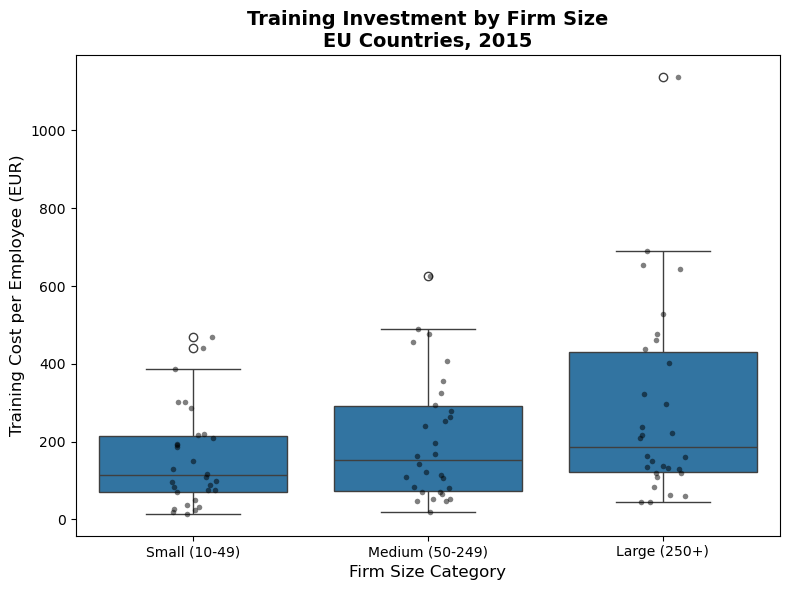

In [52]:
# =============================================================================
# Descriptive Data: Training Cost by Firm Size
# =============================================================================

if all(c in merged_df.columns for c in ['training_small', 'training_medium', 'training_large']):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Reshape for plotting
    plot_data = merged_df.melt(
        id_vars=['country', 'region'],
        value_vars=['training_small', 'training_medium', 'training_large'],
        var_name='firm_size',
        value_name='training_cost'
    )

    size_labels = {
        'training_small': 'Small (10-49)', 
        'training_medium': 'Medium (50-249)', 
        'training_large': 'Large (250+)'
    }
    plot_data['firm_size'] = plot_data['firm_size'].map(size_labels)

    sns.boxplot(data=plot_data, x='firm_size', y='training_cost', ax=ax)
    sns.stripplot(data=plot_data, x='firm_size', y='training_cost', 
                  color='black', alpha=0.5, size=4, ax=ax)

    ax.set_xlabel('Firm Size Category', fontsize=12)
    ax.set_ylabel('Training Cost per Employee (EUR)', fontsize=12)
    ax.set_title('Training Investment by Firm Size\nEU Countries, 2015', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('fig2_training_by_firmsize.png', dpi=150, bbox_inches='tight')
    print("Saved: fig2_training_by_firmsize.png")
    plt.show()
else:
    print("Firm size columns not available for this plot")

In [84]:
# MODEL 5: TRAINING + EDUCATION + FIRM SIZE CONTROL
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load firm size data
firm_df = pd.read_csv('sorted_estat_trng_cvt_17s_final.csv')

# Filter by unit EUR
if 'unit' in firm_df.columns:
    firm_df = firm_df[firm_df['unit'] == 'EUR'].reset_index(drop=True)

# Rename geo to country
firm_df.rename(columns={'geo': 'country'}, inplace=True)

# Create firm size categories based on size_emp column
# Small: 10-49, Mid: 50-249, Large: GE250
firm_size_data = firm_df.pivot_table(
    index='country', 
    columns='size_emp', 
    values='2015_value', 
    aggfunc='mean'
).reset_index()

# Rename columns
firm_size_data.columns.name = None
firm_size_data = firm_size_data.rename(columns={
    'S_GE10': 'training_cost_all',  # All firms (if exists)
    '10-49': 'training_cost_small',
    '50-249': 'training_cost_mid',
    'GE250': 'training_cost_large'
})

# Calculate firm size composition (proportion of training cost by firm size)
# Or use as dummy variables for presence of each firm size

# Merge with existing merged_df_clean
merged_df_m5 = pd.merge(merged_df_clean, firm_size_data, on='country', how='inner')

# Create dummy variables for firm size (using median split or actual composition)
# Here we use the training cost by firm size as proxies for firm composition

# Convert to numeric
merged_df_m5['training_cost_small'] = pd.to_numeric(merged_df_m5['training_cost_small'], errors='coerce')
merged_df_m5['training_cost_mid'] = pd.to_numeric(merged_df_m5['training_cost_mid'], errors='coerce')
merged_df_m5['training_cost_large'] = pd.to_numeric(merged_df_m5['training_cost_large'], errors='coerce')

# Calculate firm size composition as share of total training cost
merged_df_m5['total_training'] = merged_df_m5['training_cost_small'] + merged_df_m5['training_cost_mid'] + merged_df_m5['training_cost_large']
merged_df_m5['pct_mid'] = merged_df_m5['training_cost_mid'] / merged_df_m5['total_training']
merged_df_m5['pct_large'] = merged_df_m5['training_cost_large'] / merged_df_m5['total_training']

# Drop missing values
merged_df_m5 = merged_df_m5.dropna(subset=['training_cost_avg', 'gdp_2015', 'education_tertiary', 'pct_mid', 'pct_large']).reset_index(drop=True)

# Define X and y
X_m5 = pd.DataFrame({
    'training_cost_avg': merged_df_m5['training_cost_avg'].astype(float),
    'education_tertiary': merged_df_m5['education_tertiary'].astype(float),
    'MidFirm': merged_df_m5['pct_mid'].astype(float),
    'LargeFirm': merged_df_m5['pct_large'].astype(float)
})

X_m5 = sm.add_constant(X_m5)
y = merged_df_m5['gdp_2015'].astype(float)

# Fit model
model_m5 = sm.OLS(y, X_m5).fit()

# Print summary
print("=" * 90)
print("MODEL 5: TRAINING + EDUCATION + FIRM SIZE CONTROL (GDP 2015)")
print("=" * 90)
print(model_m5.summary())

# Extract coefficients
intercept_m5 = model_m5.params['const']
slope_training = model_m5.params['training_cost_avg']
slope_education = model_m5.params['education_tertiary']
slope_mid = model_m5.params['MidFirm']
slope_large = model_m5.params['LargeFirm']

# Print equation
print("\n" + "=" * 90)
print("REGRESSION EQUATION")
print("=" * 90)
print(f"\nGDP_2015 = {intercept_m5:.1f} + {slope_training:.1f} × TrainingCost + {slope_education:.1f} × Education + {slope_mid:.1f} × MidFirm + {slope_large:.1f} × LargeFirm + ε")

# Markdown formula
print("\n" + "=" * 90)
print("MARKDOWN FORMULA (copy-paste ready):")
print("=" * 90)
print(f"$$\\mathtt{{GDPpercapita}}={intercept_m5:.1f}+{slope_training:.1f}×\\mathtt{{TrainingCost}}+{slope_education:.1f}×\\mathtt{{Education}}+{slope_mid:.1f}×\\mathtt{{MidFirm}}+{slope_large:.1f}×\\mathtt{{LargeFirm}}+ε$$")

# Compare with Model 2
print("\n" + "=" * 90)
print("MODEL COMPARISON")
print("=" * 90)
print(f"Model 2 (Education Control): β₁ = 74.68")
print(f"Model 5 (Education + Firm Size): β₁ = {slope_training:.2f}")
print(f"Coefficient change: {74.68 - slope_training:.2f} ({(74.68 - slope_training)/74.68*100:.1f}% change)")

MODEL 5: TRAINING + EDUCATION + FIRM SIZE CONTROL (GDP 2015)
                            OLS Regression Results                            
Dep. Variable:               gdp_2015   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     11.61
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           3.20e-05
Time:                        23:02:40   Log-Likelihood:                -290.85
No. Observations:                  27   AIC:                             591.7
Df Residuals:                      22   BIC:                             598.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

## Model 6

In [85]:
# STRATIFIED REGRESSION ANALYSIS BY FIRM SIZE (with Education Control)
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load firm size data
firm_df = pd.read_csv('sorted_estat_trng_cvt_17s_final.csv')

# Filter by unit EUR
if 'unit' in firm_df.columns:
    firm_df = firm_df[firm_df['unit'] == 'EUR'].reset_index(drop=True)

# Rename geo to country
firm_df.rename(columns={'geo': 'country'}, inplace=True)

# Create firm size categories based on size_emp column
firm_size_data = firm_df.pivot_table(
    index='country', 
    columns='size_emp', 
    values='2015_value', 
    aggfunc='mean'
).reset_index()

# Rename columns
firm_size_data.columns.name = None
firm_size_data = firm_size_data.rename(columns={
    '10-49': 'training_cost_small',
    '50-249': 'training_cost_mid',
    'GE250': 'training_cost_large'
})

# Merge with existing merged_df_clean
df_strat = pd.merge(merged_df_clean, firm_size_data[['country', 'training_cost_small', 'training_cost_mid', 'training_cost_large']], on='country', how='inner')

# Convert to numeric
df_strat['training_cost_small'] = pd.to_numeric(df_strat['training_cost_small'], errors='coerce')
df_strat['training_cost_mid'] = pd.to_numeric(df_strat['training_cost_mid'], errors='coerce')
df_strat['training_cost_large'] = pd.to_numeric(df_strat['training_cost_large'], errors='coerce')

# Drop missing values
df_strat = df_strat.dropna(subset=['gdp_2015', 'education_tertiary', 
                                    'training_cost_small', 'training_cost_mid', 
                                    'training_cost_large']).reset_index(drop=True)

print("=" * 90)
print("STRATIFIED REGRESSION ANALYSIS BY FIRM SIZE (with Education Control)")
print("=" * 90)
print(f"Countries included: {len(df_strat)}")

y = df_strat['gdp_2015'].astype(float)

# ===== SMALL FIRMS =====
X_small = pd.DataFrame({
    'training_cost_small': df_strat['training_cost_small'].astype(float),
    'education_tertiary': df_strat['education_tertiary'].astype(float)
})
X_small = sm.add_constant(X_small)
model_small = sm.OLS(y, X_small).fit()

print("\n" + "=" * 90)
print("SMALL FIRMS (10-49 employees)")
print("=" * 90)
print(model_small.summary())

# ===== MID FIRMS =====
X_mid = pd.DataFrame({
    'training_cost_mid': df_strat['training_cost_mid'].astype(float),
    'education_tertiary': df_strat['education_tertiary'].astype(float)
})
X_mid = sm.add_constant(X_mid)
model_mid = sm.OLS(y, X_mid).fit()

print("\n" + "=" * 90)
print("MID FIRMS (50-249 employees)")
print("=" * 90)
print(model_mid.summary())

# ===== LARGE FIRMS =====
X_large = pd.DataFrame({
    'training_cost_large': df_strat['training_cost_large'].astype(float),
    'education_tertiary': df_strat['education_tertiary'].astype(float)
})
X_large = sm.add_constant(X_large)
model_large = sm.OLS(y, X_large).fit()

print("\n" + "=" * 90)
print("LARGE FIRMS (≥250 employees)")
print("=" * 90)
print(model_large.summary())

# ===== SUMMARY COMPARISON =====
print("\n" + "=" * 90)
print("STRATIFIED REGRESSION SUMMARY")
print("=" * 90)
print(f"{'Firm Size':<20} {'Training β':<15} {'Education β':<15} {'R²':<10} {'p-value (Training)':<20}")
print("-" * 90)
print(f"{'Small (10-49)':<20} {model_small.params['training_cost_small']:<15.2f} {model_small.params['education_tertiary']:<15.2f} {model_small.rsquared:<10.3f} {model_small.pvalues['training_cost_small']:<20.4f}")
print(f"{'Mid (50-249)':<20} {model_mid.params['training_cost_mid']:<15.2f} {model_mid.params['education_tertiary']:<15.2f} {model_mid.rsquared:<10.3f} {model_mid.pvalues['training_cost_mid']:<20.4f}")
print(f"{'Large (≥250)':<20} {model_large.params['training_cost_large']:<15.2f} {model_large.params['education_tertiary']:<15.2f} {model_large.rsquared:<10.3f} {model_large.pvalues['training_cost_large']:<20.4f}")

# ===== MARKDOWN EQUATIONS =====
print("\n" + "=" * 90)
print("MARKDOWN FORMULAS (copy-paste ready):")
print("=" * 90)

print(f"\n**Small Firms (10-49 employees):** R² = {model_small.rsquared:.3f}, p = {model_small.pvalues['training_cost_small']:.4f}")
print(f"$$\\mathtt{{GDPpercapita}}={model_small.params['const']:.1f}+{model_small.params['training_cost_small']:.1f}×\\mathtt{{TrainingCost_{{small}}}}+{model_small.params['education_tertiary']:.1f}×\\mathtt{{Education}}+ε$$")

print(f"\n**Mid Firms (50-249 employees):** R² = {model_mid.rsquared:.3f}, p = {model_mid.pvalues['training_cost_mid']:.4f}")
print(f"$$\\mathtt{{GDPpercapita}}={model_mid.params['const']:.1f}+{model_mid.params['training_cost_mid']:.1f}×\\mathtt{{TrainingCost_{{mid}}}}+{model_mid.params['education_tertiary']:.1f}×\\mathtt{{Education}}+ε$$")

print(f"\n**Large Firms (≥250 employees):** R² = {model_large.rsquared:.3f}, p = {model_large.pvalues['training_cost_large']:.4f}")
print(f"$$\\mathtt{{GDPpercapita}}={model_large.params['const']:.1f}+{model_large.params['training_cost_large']:.1f}×\\mathtt{{TrainingCost_{{large}}}}+{model_large.params['education_tertiary']:.1f}×\\mathtt{{Education}}+ε$$")

# ===== KEY INSIGHT =====
print("\n" + "=" * 90)
print("KEY INSIGHT")
print("=" * 90)
print(f"Training coefficient comparison:")
print(f"  Small Firms:  β = {model_small.params['training_cost_small']:.1f}")
print(f"  Mid Firms:    β = {model_mid.params['training_cost_mid']:.1f}")
print(f"  Large Firms:  β = {model_large.params['training_cost_large']:.1f}")
print(f"\nAll three are statistically significant, suggesting training is effective across all firm sizes.")

STRATIFIED REGRESSION ANALYSIS BY FIRM SIZE (with Education Control)
Countries included: 27

SMALL FIRMS (10-49 employees)
                            OLS Regression Results                            
Dep. Variable:               gdp_2015   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     27.21
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           6.76e-07
Time:                        23:15:05   Log-Likelihood:                -290.19
No. Observations:                  27   AIC:                             586.4
Df Residuals:                      24   BIC:                             590.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]

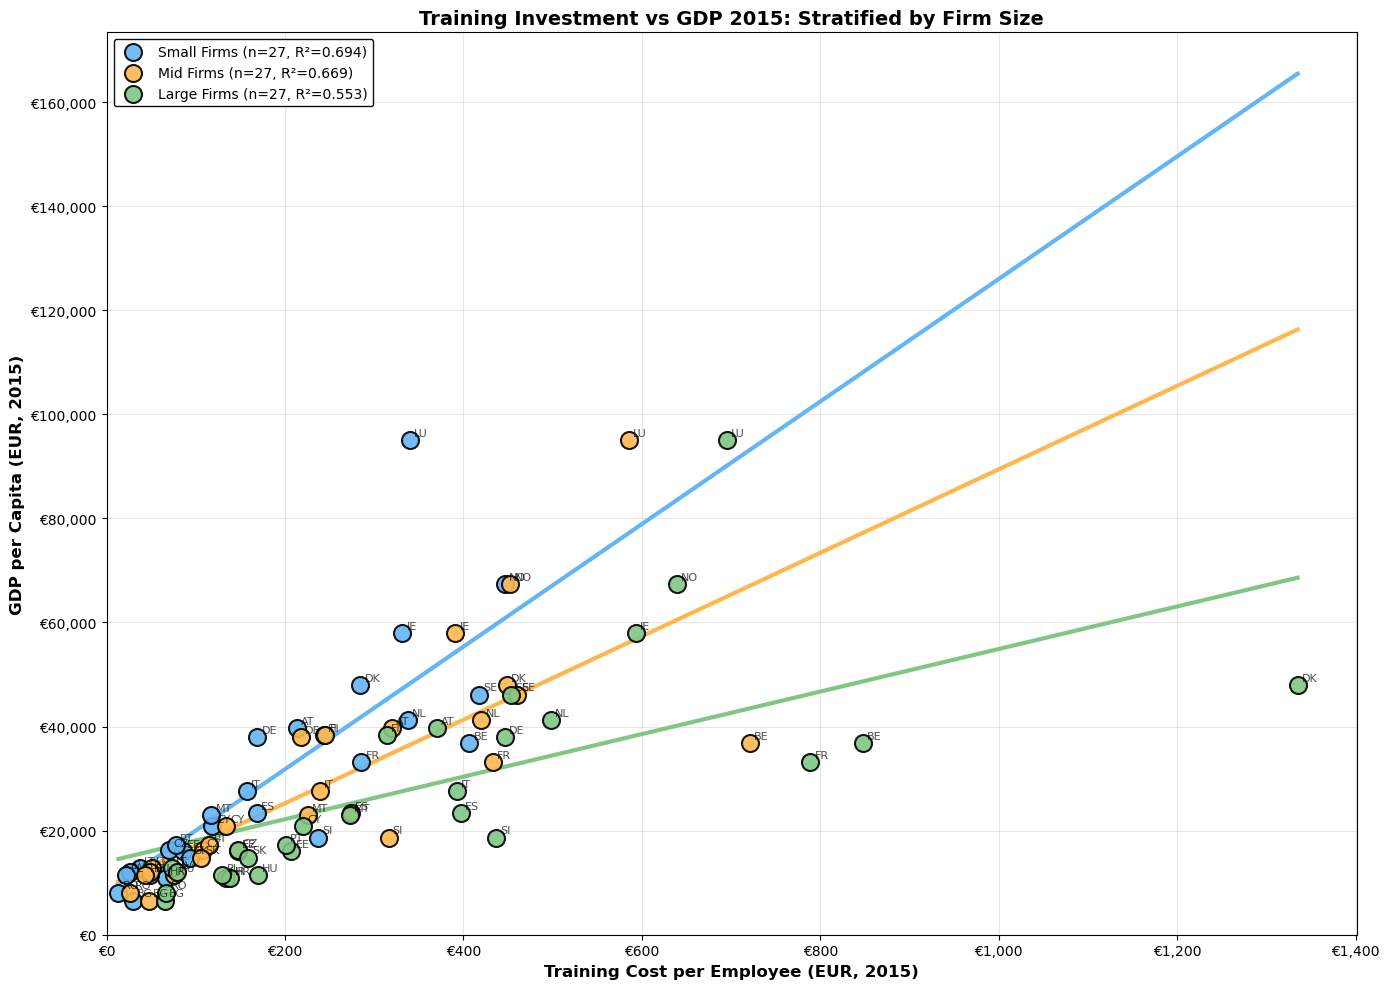


✓ Graph saved as 'stratified_firmsize_gdp2015.png'


In [86]:

# STRATIFIED REGRESSION GRAPH BY FIRM SIZE (GDP 2015, with Education Control)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define colors (matching original graph exactly)
colors = {
    'small': '#64B5F6',  # Blue
    'mid': '#FFB74D',    # Orange
    'large': '#81C784'   # Green
}

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Plot scatter points for each firm size
ax.scatter(df_strat['training_cost_small'], df_strat['gdp_2015'],
           c=colors['small'], s=150, alpha=0.9, label=f'Small Firms (n={len(df_strat)}, R²={model_small.rsquared:.3f})',
           edgecolors='black', linewidths=1.5, zorder=3)

ax.scatter(df_strat['training_cost_mid'], df_strat['gdp_2015'],
           c=colors['mid'], s=150, alpha=0.9, label=f'Mid Firms (n={len(df_strat)}, R²={model_mid.rsquared:.3f})',
           edgecolors='black', linewidths=1.5, zorder=3)

ax.scatter(df_strat['training_cost_large'], df_strat['gdp_2015'],
           c=colors['large'], s=150, alpha=0.9, label=f'Large Firms (n={len(df_strat)}, R²={model_large.rsquared:.3f})',
           edgecolors='black', linewidths=1.5, zorder=3)

# Add country labels
for idx, row in df_strat.iterrows():
    ax.annotate(row['country'], (row['training_cost_small'], row['gdp_2015']),
                fontsize=8, alpha=0.7, xytext=(3, 3), textcoords='offset points')
    ax.annotate(row['country'], (row['training_cost_mid'], row['gdp_2015']),
                fontsize=8, alpha=0.7, xytext=(3, 3), textcoords='offset points')
    ax.annotate(row['country'], (row['training_cost_large'], row['gdp_2015']),
                fontsize=8, alpha=0.7, xytext=(3, 3), textcoords='offset points')

# Calculate regression lines (using mean education for prediction)
education_mean = df_strat['education_tertiary'].mean()

# X range for lines
x_min = min(df_strat['training_cost_small'].min(), df_strat['training_cost_mid'].min(), df_strat['training_cost_large'].min())
x_max = max(df_strat['training_cost_small'].max(), df_strat['training_cost_mid'].max(), df_strat['training_cost_large'].max())
x_line = np.linspace(x_min, x_max, 300)

# Small firms regression line
y_line_small = model_small.params['const'] + model_small.params['training_cost_small'] * x_line + model_small.params['education_tertiary'] * education_mean
ax.plot(x_line, y_line_small, color=colors['small'], linewidth=3, zorder=2)

# Mid firms regression line
y_line_mid = model_mid.params['const'] + model_mid.params['training_cost_mid'] * x_line + model_mid.params['education_tertiary'] * education_mean
ax.plot(x_line, y_line_mid, color=colors['mid'], linewidth=3, zorder=2)

# Large firms regression line
y_line_large = model_large.params['const'] + model_large.params['training_cost_large'] * x_line + model_large.params['education_tertiary'] * education_mean
ax.plot(x_line, y_line_large, color=colors['large'], linewidth=3, zorder=2)

# Formatting
ax.set_xlabel('Training Cost per Employee (EUR, 2015)', fontsize=12, fontweight='bold')
ax.set_ylabel('GDP per Capita (EUR, 2015)', fontsize=12, fontweight='bold')
ax.set_title('Training Investment vs GDP 2015: Stratified by Firm Size', fontsize=14, fontweight='bold')

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

# Format x-axis as currency
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

# Set axis limits
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Legend
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, edgecolor='black')

# Grid
ax.grid(alpha=0.3, zorder=1)

plt.tight_layout()
plt.savefig('stratified_firmsize_gdp2015.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graph saved as 'stratified_firmsize_gdp2015.png'")